<a href="https://colab.research.google.com/github/Mihail-Chr/projects/blob/main/ML/time%20series/time%20series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [1]:
! pip install catboost
! pip install phik
! pip install torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.0/679.0 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 123.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-c

## Подготовка

In [4]:
# общие библиотеки Pandas
from IPython.display import clear_output
import pandas as pd
import numpy as np
import seaborn as sns
import re
import datetime as dt
import calendar

from statsmodels.tsa.seasonal import seasonal_decompose



from phik.report import plot_correlation_matrix
from phik import phik_matrix
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor, Pool


#import torch
import torch.nn as nn

from sklearn.metrics import (confusion_matrix,mean_squared_error,log_loss,root_mean_squared_error)


from sklearn.preprocessing import (StandardScaler,OneHotEncoder)
#from feature_engine.encoding import OneHotEncoder

from sklearn.model_selection import (train_test_split,GridSearchCV,cross_val_score,TimeSeriesSplit)

#from sklearn.linear_model import LinearRegression ,LogisticRegression,Ridge
from sklearn.dummy import  DummyRegressor

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
#from sklearn.impute import SimpleImputer
#from optuna import distributions,visualization
#from optuna.integration import OptunaSearchCV

import warnings
from sklearn.exceptions import ConvergenceWarning
ConvergenceWarning('ignore')
import sys
import os

#random.seed(0)
np.random.seed(0)
#torch.manual_seed(0)
#torch.use_deterministic_algorithms(True)

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = ('ignore::UserWarning,ignore::ConvergenceWarning,ignore::RuntimeWarning')

#optuna.logging.set_verbosity(optuna.logging.WARNING)

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:,.2f}'.format
pd.DataFrame.iteritems = pd.DataFrame.items
RANDOM_STATE = 255
TEST_SIZE = 0.1
warnings.filterwarnings('ignore')

In [5]:
# функиция преобразования в bool и запоминания значений в словарь
def bul(dat,col,tru,nt):
    dat[col][dat[col]==tru] = 1
    dat[col][dat[col]==nt] = 0
    dat[col]=dat[col].astype('bool')
    voc_k[col] = (nt,tru)

In [6]:
def show_progress(x, y, y_pred, loss):

    y_pred = y_pred.detach() #*std_T + men_T
    loss = loss.item()
    clear_output(wait=True)

    # Строим новый график
    plt.figure(figsize=(10, 7))
    #plt.scatter(x, y, alpha=0.75)
    #plt.scatter(x, y_pred, color='orange', linewidth=5)
    plt.scatter(y, y, alpha=0.75)
    plt.scatter(y, y_pred, color='orange', linewidth=5)
    plt.xlabel('Таргет')
    plt.ylabel('Предсказание', color='orange')
    plt.show()

    print(f"RMSE = {loss:.3f}")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


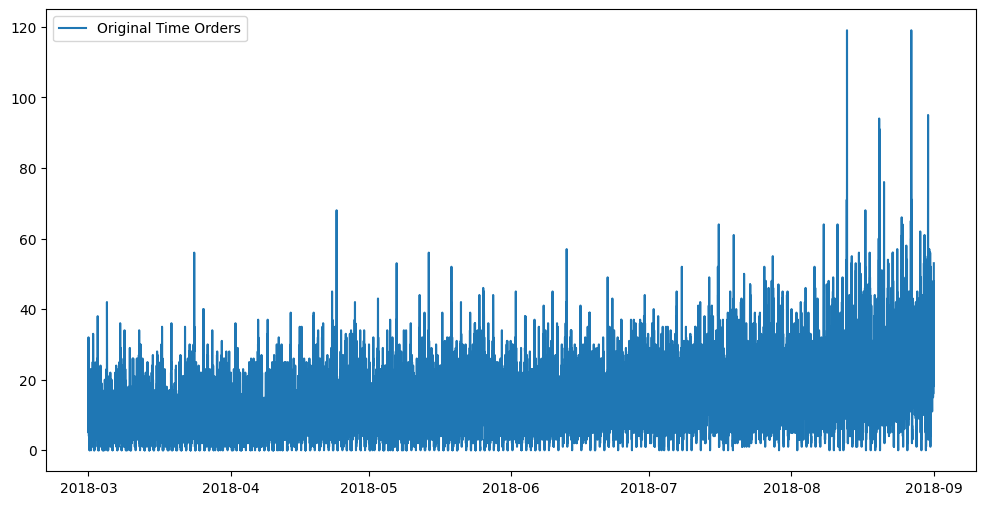

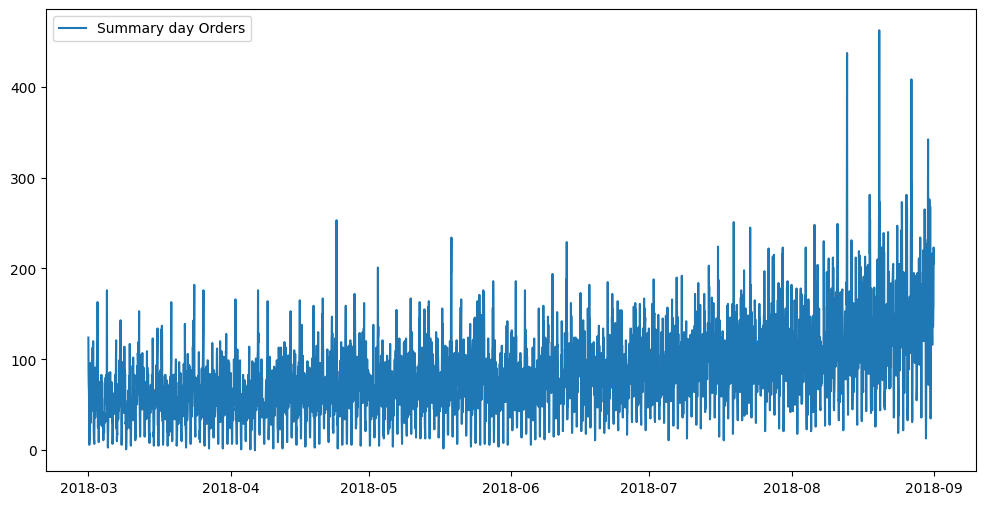

In [8]:
# загрузка данных и просмотр
data = pd.read_csv('/content/drive/MyDrive/data//taxi.csv', index_col=[0], parse_dates=[0])
data.info()
data.sort_index(inplace=True)
plt.figure(figsize=(12, 6))
plt.plot(data, label='Original Time Orders')
plt.legend()
#data.plot()
data = data.resample('1H').sum()
df1 = data.copy()
df1.info()
display(df1.tail(5))
plt.figure(figsize=(12, 6))
plt.plot(df1, label='Summary day Orders')
plt.legend()

#

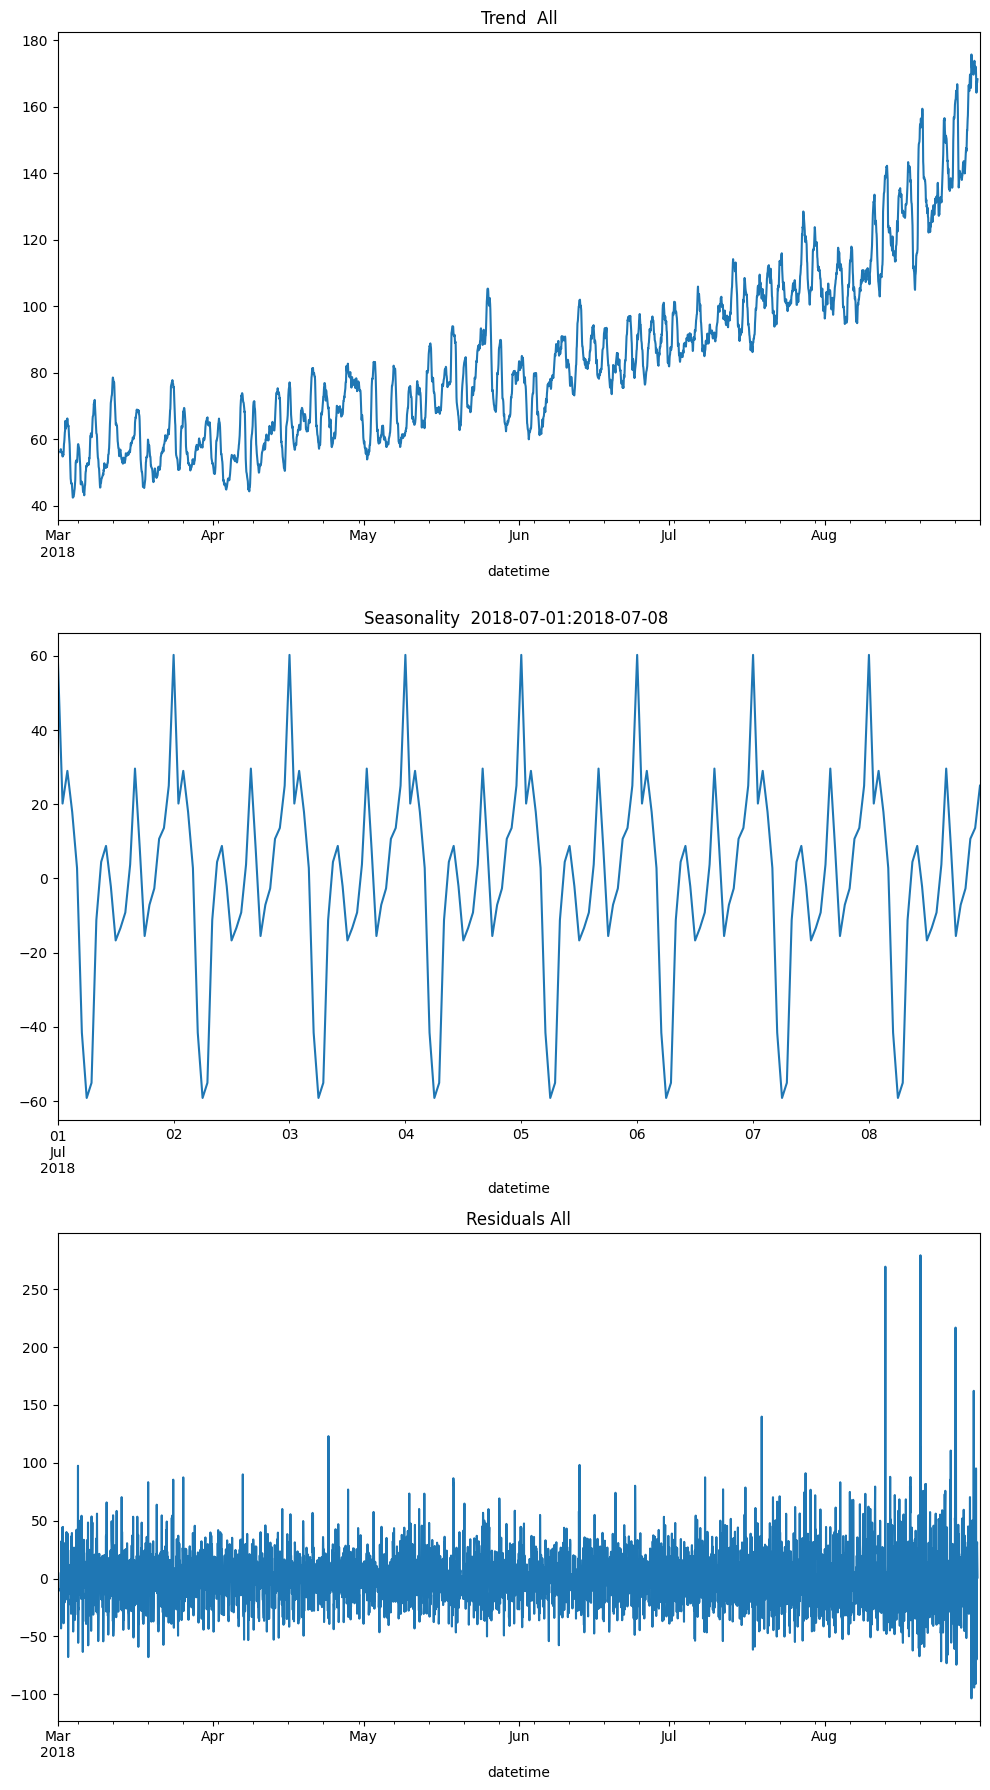

In [9]:
decomposed = seasonal_decompose(df1)# < напишите код здесь >

plt.figure(figsize=(10, 18))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend  All')
plt.subplot(312)
decomposed.seasonal['2018-07-01':'2018-07-08'].plot(ax=plt.gca())
# < напишите код здесь >
plt.title('Seasonality  2018-07-01:2018-07-08 ')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
# < напишите код здесь >
plt.title('Residuals All')
plt.tight_layout()

### Выводы по графикам загузки и сезонности:
- данные монотонны (согласно графика)
- наблюдается повысительные тренд от месяца к месяцу , такой, что максимальные значения мая менmit минимальным в авугусте
- сезонность посуточная присутствует
- наблюдается высокое значение "остатков" а августе

In [10]:
def make_f2 (dt):
    if  1<dt<5 : return('early morning')##
    elif 5<=dt<=7 : return('morning')##
    elif 7<dt<=11 : return('late morning')##
    elif 11<dt<= 14 : return('afternoon')##
    elif 14<dt<= 18 : return('early evening')##
    elif 18<dt< 23 : return('late evening')##
    else:  return('midnidgt')#



In [11]:
def make_times(data) :
    data['hour'] = data.index.hour
    #data['month'] = data.index
    #data['month'] = data['month'].apply(lambda x:x.strftime("%B"))
    data['day'] = data.index.day
    data['dayofweek'] = data.index#.dayofweek
    data['dayofweek'] = data['dayofweek'].apply(lambda x:x.strftime(("%A")))
    data['day_times'] = data['hour'].copy()
    data['day_times'] = data['day_times'].apply(lambda x:make_f2(x))

    return(data)


In [12]:
# создание дополнительных признаков
df1 = data.copy()
df1 = make_times(df1)
df3=df1.copy()

max_lag = 24
max_roll = 24
for lag in range(1, max_lag + 1):
        df1['lag_{}'.format(lag)] = (df1['num_orders'].shift(lag))

df1['lag_48'] = (df1['num_orders'].shift(48))
df1['lag_168'] = (df1['num_orders'].shift(168))
df1['rolling_mean'] = df1['num_orders'].shift().rolling(max_roll).mean()

display(df1.head())
display(df3.head())

#df.info()

,num_orders,hour,day,dayofweek,day_times,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_48,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,1,Thursday,midnidgt,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,Thursday,midnidgt,124.00,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,1,Thursday,early morning,85.00,124.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,Thursday,early morning,71.00,85.00,124.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,1,Thursday,early morning,66.00,71.00,85.00,124.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,num_orders,hour,day,dayofweek,day_times
datetime,,,,,
2018-03-01 00:00:00,124,0,1,Thursday,midnidgt
2018-03-01 01:00:00,85,1,1,Thursday,midnidgt
2018-03-01 02:00:00,71,2,1,Thursday,early morning
2018-03-01 03:00:00,66,3,1,Thursday,early morning
2018-03-01 04:00:00,43,4,1,Thursday,early morning


## Анализ

'анализ по дням '

<Axes: xlabel='day'>

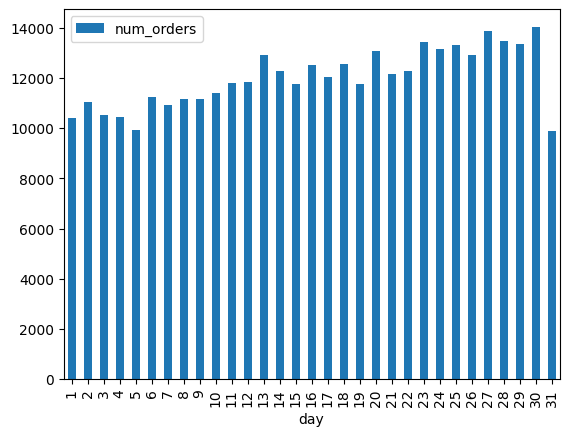

In [13]:
# анализ по дням
df_month = df3.groupby('day')[['num_orders']].sum()
df_month.columns = ['num_orders']
#display (df_month)
display('анализ по дням ')
df_month.plot.bar()

,num_orders
dayofweek,
Friday,59059
Monday,56314
Thursday,55508
Saturday,52321
Wednesday,52263
Sunday,49291
Tuesday,48055


'анализ по дням недели'

<Axes: xlabel='dayofweek'>

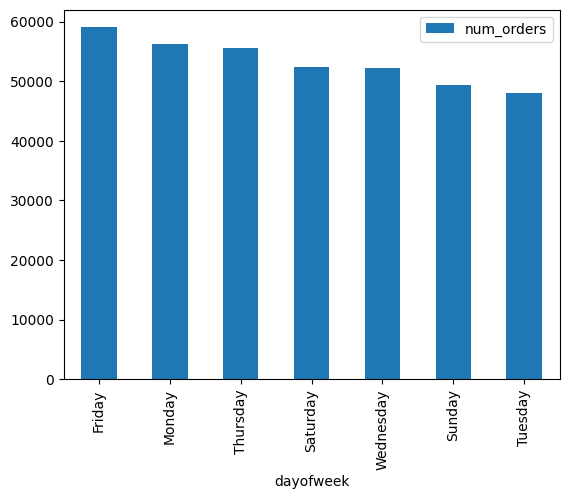

In [14]:
# анализ по дням
df_month = df3.groupby('dayofweek')[['num_orders']].sum().sort_values('num_orders',ascending=False)
df_month.columns = ['num_orders']
display (df_month)
display('анализ по дням недели')
df_month.plot.bar()

'анализ по часам'

<Axes: xlabel='hour'>

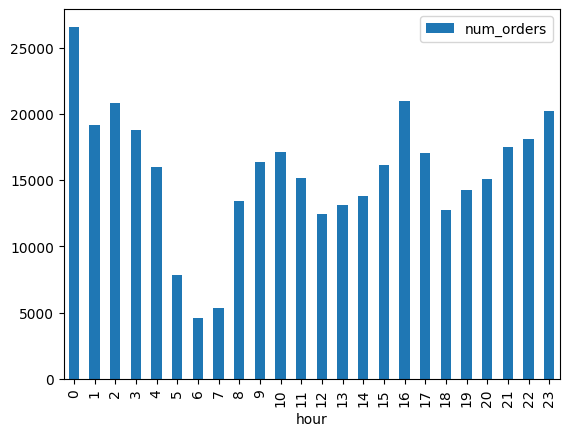

In [15]:
# анализ по часам
df_month = df3.groupby('hour')[['num_orders']].sum()#.sort_values('num_orders',ascending=False)
df_month.columns = ['num_orders']
#display (df_month)
display('анализ по часам')
df_month.plot.bar()

,num_orders
day_times,
afternoon,39370
early evening,67008
early morning,55568
late evening,64935
late morning,62098
midnidgt,65970
morning,17862


'анализ по времени суток'

<Axes: xlabel='day_times'>

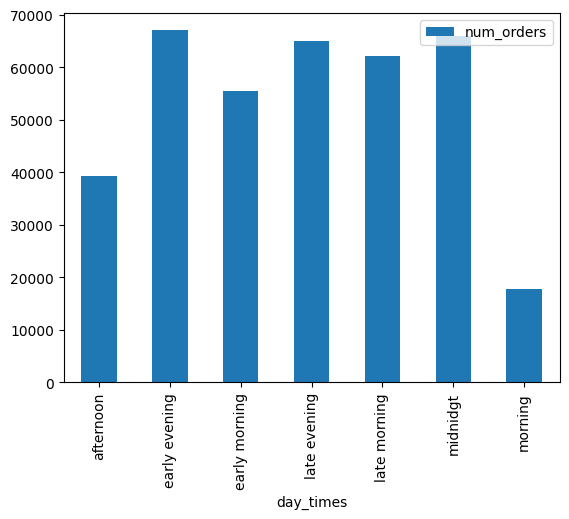

In [16]:
# анализ по времени суток
df_month = df3.groupby('day_times')[['num_orders']].sum()#.sort_values('num_orders',ascending=False)
df_month.columns = ['num_orders']
display (df_month)
display('анализ по времени суток')
df_month.plot.bar()

### PHIK матрица

In [18]:
df_c = df1.copy()
df_c.info()
#_times .drop(['hour'],axis=1)
df_c=df_c.astype('object')
interval_cols = ['rolling_mean']
#df_c[interval_cols] = df_c[interval_cols].astype('float64')
# 'PHIK матрица'
display("PHIK матрица ")
phik_overview = phik_matrix(df_c, interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1,
    color_map="YlOrRd",
    title=r"correlation $\phi_K$",
    fontsize_factor=1.2,
    figsize=(14,14),
)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: h
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   hour          4416 non-null   int32  
 2   day           4416 non-null   int32  
 3   dayofweek     4416 non-null   object 
 4   day_times     4416 non-null   object 
 5   lag_1         4415 non-null   float64
 6   lag_2         4414 non-null   float64
 7   lag_3         4413 non-null   float64
 8   lag_4         4412 non-null   float64
 9   lag_5         4411 non-null   float64
 10  lag_6         4410 non-null   float64
 11  lag_7         4409 non-null   float64
 12  lag_8         4408 non-null   float64
 13  lag_9         4407 non-null   float64
 14  lag_10        4406 non-null   float64
 15  lag_11        4405 non-null   float64
 16  lag_12        4404 non-null   float64
 17  lag_13        4403 non-null

'PHIK матрица '

KeyboardInterrupt: 

### Выводы по анализу данных:
    - с каждым месяцем количество заказов возрастает
    - в начале месяца количество заказов меньше, уменьшение значения 31 числа связанно с тем, что не во всех месяцах есть 31
    - меньше всего заказов по субботам и четвергам
    - с 4 часов утра и до 8 активность заказов падает, возрастает в 16 и начиная с 20 часов до 12 ночи
    - анализ экстремальных месяцев показал похожие показатели активности по часам
    - анализ остатков (значительный "выброс") предполагает значительное увеличение целевого значения
    - наблюдается взаимная коррелляция между  признаками day_times и hour
    - целевой признак зависим от day_times, hour,  не считая lag и rooling_mean? что естественно

In [ ]:

from statsmodels.graphics import tsaplots

taxi = pd.read_csv("'/content/drive/MyDrive/data//taxi.csv'", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show()


## Обучение

In [ ]:
df2 = df1.dropna().copy()
X_train, X_test, y_train, y_test = train_test_split(
    df2.drop(['num_orders'],axis=1), #'day_times','hour',
    df2['num_orders'],
    test_size = TEST_SIZE,
    shuffle=False)

X_train.info()

### модель Catboost

In [ ]:
X_train_cat = X_train.copy()
X_test_cat = X_test.copy()
cat_col = ['day_times',
           #'month',
           'dayofweek',
            ]

num_col = ['rolling_mean']
X_train_cat[cat_col] = X_train_cat[cat_col].astype('category')
X_test_cat[cat_col] = X_test_cat[cat_col].astype('category')

train_pool = Pool(data=X_train_cat, label=y_train, cat_features= cat_col)
test_pool = Pool(data=X_test_cat, label=y_test, cat_features= cat_col)

params = {
    'iterations': 1000,
    'learning_rate': 0.01,
    'loss_function': 'RMSE',
    'early_stopping_rounds': 100,
    'verbose': False,
    'random_seed': RANDOM_STATE,
    'cat_features': cat_col
    }

model_cat = CatBoostRegressor(**params) #,task_type="GPU",devices='0')

param_grid = {'depth': range(5, 8),
              'min_data_in_leaf':range(1,3)}

tscv = TimeSeriesSplit(n_splits=5)

cat_search = GridSearchCV(CatBoostRegressor(**params),
                          param_grid,
                          cv=tscv,
                          scoring='neg_root_mean_squared_error',
                          error_score='raise',
                          verbose=False,
                          n_jobs=-1)
                          #verbose = False)



cat_search.fit(X_train_cat, y_train)


#best_param={**grid_search_result['params'] }
display ('Лучшая модель',cat_search.best_estimator_)
display ('Лучшие параметры',cat_search.best_params_)#(**params))
display ('лучшая метрика RMSE train',cat_search.best_estimator_.get_best_score())

In [ ]:
#display ('Лучшая модель',cat_search.best_estimator_.get_param())#['params'])
display ('Лучшие параметры',cat_search.best_params_)#(**params))
display ('лучшая метрика RMSE train',cat_search.best_estimator_.get_best_score())
#print('лучшая метрика RMSE train',cat_search.score_)


In [ ]:
df_rmse = pd.DataFrame()
df_rmse.loc['RMSE','CatBoost']=cat_search.best_estimator_.get_best_score()['learn']['RMSE']#[-1]
display(df_rmse)

In [ ]:
#display (grid_search_result['params'])#['F1'])

feature_importance=cat_search.best_estimator_.get_feature_importance(prettified=True)
print('RMSE = ',cat_search.best_estimator_.get_best_score())

display(feature_importance)
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=feature_importance,x=feature_importance['Importances'],
                 y=feature_importance['Feature Id'])
ax.set_title('Важность признаков', fontsize=16)
plt.show()

In [ ]:
print('лучшая метрика RMSE train',cat_search.best_estimator_.get_best_score())

pred_cat=cat_search.best_estimator_.predict(X_test)#,y_test)#.astype('bool'))#.astype('int8'))

print('RSME test Catboost test ',root_mean_squared_error(y_test,pred_cat))

### модель Ridge Reg

In [ ]:
# Ridge Reg

ohe_columns=['day_times','dayofweek',]
num_columns=X_train.columns.drop(ohe_columns)
#['hour','day','lag_1','lag_2','lag_3','lag_4','lag_5','lag_6','rolling_mean']
#display (ohe_columns,num_columns)

data_preprocessor = ColumnTransformer(
    [('ohe',  OneHotEncoder(handle_unknown='ignore',sparse_output=False), ohe_columns),
     ('num', StandardScaler(), num_columns)
    ],
    #verbose_feature_names_out=False,
    remainder='passthrough'
)


# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', Ridge(max_iter=500,random_state=RANDOM_STATE))])

# параметры для GridSCV
param_grid ={#'models': Ridge(max_iter=300,random_state=RANDOM_STATE),
             'models__alpha': np.arange(0.01, 0.2, 0.05),# distributions.FloatDistribution(0.1, 1, step=0.1),
             'models__tol': np.arange(0.001, 0.05, 0.002)} #distributions.FloatDistribution(0.1, 1, step=0.1),
             #'data_preprocessor__num': ([StandardScaler(),  'passthrough'])}



GridSCV = GridSearchCV(pipe_final,
                       param_grid=param_grid,
                       cv=tscv,
                       scoring='neg_root_mean_squared_error',
                       error_score='raise',
                       verbose=False,
                       n_jobs=-1
                       )

GridSCV.fit(X_train, y_train)

print ('Лучшая модель и её параметры:\n\n', GridSCV.best_estimator_)
print ('Метрика лучшей модели RSME:', -GridSCV.best_score_)

In [ ]:
pred_rg = GridSCV.best_estimator_.predict(X_train)
RSME_d_tr = root_mean_squared_error(y_train,pred_rg)
print ('RSME Ridge train = ',RSME_d_tr)
print ('test')
pred_rg = GridSCV.best_estimator_.predict(X_test)
RSME_d_te = root_mean_squared_error(y_test,pred_rg)
print ('RSME Ridge test = ',RSME_d_te)

df_rmse.loc['RMSE','Ridge']=RSME_d_tr
display(df_rmse)

### Нейронная модель

In [ ]:

X1_tr = data_preprocessor.fit_transform(X_train)
X1_train_n = pd.DataFrame(X1_tr)
X1_tst = data_preprocessor.transform(X_test)
X1_test_n = pd.DataFrame(X1_tst)

In [ ]:
col_t=X_test.columns
X_train_n = torch.FloatTensor(X1_train_n.values)
X_test_n = torch.FloatTensor(X1_test_n.values)
y_train_n = torch.FloatTensor(y_train.values)
y_test_n = torch.FloatTensor(y_test.values)

In [ ]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1,
                 n_hidden_neurons_2,n_hidden_neurons_3,
                 n_hidden_neurons_4,n_out_neurons):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.dp1 = nn.Dropout(p=0.2)
        self.act1 = nn.ReLU()

        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.act2 = nn.Tanh()

        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.bn3 = nn.BatchNorm1d(n_hidden_neurons_3)
        self.act3 = nn.ReLU()

        self.fc4 = nn.Linear(n_hidden_neurons_3, n_hidden_neurons_4)
        self.act4 = nn.Tanh()

        self.fc5 =  nn.Linear(n_hidden_neurons_4, n_out_neurons)



    def forward(self, x):
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.act1(x)

        x = self.fc2(x)

        x = self.act2(x)

        x = self.fc3(x)
        x = self.bn3(x)
        x = self.act3(x)

        x = self.fc4(x)
        x = self.act4(x)

        x = self.fc5(x)

        return x

n_in_neurons = X_train_n.shape[1]
n_hidden_neurons_1 = 64
n_hidden_neurons_2 = 32
n_hidden_neurons_3 = 16
n_hidden_neurons_4 = 8

n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1,
          n_hidden_neurons_2,n_hidden_neurons_3,
          n_hidden_neurons_4, n_out_neurons )


optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
loss = nn.MSELoss()

batch_size = 80

num_epochs = 1000
num_batches = int((len(X_train_n)/batch_size))

p = 100000 # завышенные параметры метрики Test
p2 = 100000

for epoch in range(num_epochs):
    if  (p2 <= 45) or (p <= 45):break
    #order = np.random.permutation(len(X_train_n))
    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        optimizer.zero_grad()

        # batch_indexes = [start_index:start_index+batch_size]
        X_batch = X_train_n[start_index:start_index+batch_size]
        y_batch = y_train_n[start_index:start_index+batch_size]

        preds = net.forward(X_batch).flatten()
        loss_value = torch.sqrt(loss(preds,y_batch))
        loss_value.backward()
        optimizer.step()


        if epoch % 5 == 0 or epoch == num_epochs - 1:
            show_progress(X_batch, y_batch, preds, loss_value)
            net.eval()
            test_preds = net.forward(X_test_n).flatten()
            #p = torch.sqrt( loss(test_preds * std_T + men_T, y_test_n * std_T + men_T))
            p = torch.sqrt(loss(test_preds,y_test_n))
            if p < p2 :
                show_progress(X_batch, y_batch, preds, loss_value)
                p2 = p
                param_test = net.parameters()
                torch.save(net, 'best_test.pth')
                epoch_test = epoch
                test_pred1 = test_preds
                if  (p2 <= 45) or (p <= 45):
                    print(f"RMSE = {p2:.3f}")
                    print('количество эпох ',epoch)
                    print("Готово!")
                    print('фунция потерь',loss_value)
                    break
            else :
                if epoch_test+50 < epoch  : break


if epoch == range(num_epochs) : print('Метрика RMSE<45 на тестовой выборке при ',num_epochs,'эпохах не достугнута')

In [ ]:
display('результат лучшей модели на  тест')
show_progress(X_test_n, y_test_n, test_pred1, p2)

test_nn = torch.load('best_test.pth')
preds=test_nn (X_train_n)

display('RSME_train',loss_value.detach().numpy() )
df_rmse.loc['RMSE','NeiroNet']=loss_value.detach().numpy()
display(df_rmse)

test_nn.eval()
test_preds = test_nn(X_test_n).flatten()
#loss_value_test = torch.sqrt( loss(test_preds* std_T + men_T, y_test_n* std_T + men_T))  #np.sqrt(loss(test_preds, y_test).detach().numpy())*std_k
loss_value_test = root_mean_squared_error(test_preds.detach().numpy(), y_test)
display('RSME test',loss_value_test)


## Тестирование

In [ ]:
# построим прогноз без обучения
pred_previous = y_train.shift(fill_value=100)
rsme_con=root_mean_squared_error(y_train,pred_previous)
print('RSME train:  ',rsme_con)
df_rmse.loc['RMSE','Constant']=rsme_con
display(df_rmse)


print('test')
pred_previous = y_test.shift()
pred_previous.iloc[0] = y_train.iloc[-1]
print("RSME test:  ",root_mean_squared_error(y_test,pred_previous))

In [ ]:
# итоги моделирования
df_rmse=df_rmse.T.sort_values(['RMSE'])
df_rmse=df_rmse.reset_index()
display(df_rmse)

sns.barplot(x=df_rmse['RMSE'],y=df_rmse['index'])
plt.show()

## Выводы :
- на модели Catboost  удалось достигнуть целевого значения метрики на test данных - 39.42, хотя на train RSME = 16.61
- Ridge Reg модель показала данные по метрике на test данных - 34.57 на train данных - 21.36
- нейронная сеть показала значения метрики на тестовых данных - 47.94 train - 3.615
- данная разница в значениях метрики на train и test данных обясняется тем, что данные условно детерминироваанны и наблюдается стабильное увечение целевого значения, что можно видеть на графике шумов в начале работы
- на прогнозирование костантой целевое значение метрики на train 36.49, test не достигнуто
- подводя итоги: на предложенных данных лучшей моделью будет , наверное , Ridge модель (и на test показала лучшую метрику и разница в метрике между train и test не столь велика